In [1]:
import glob
import os
import requests
import shutil
import warnings
from random import shuffle

from itertools import product, chain
from pathlib import Path

import contextily
import dask
import dask_geopandas
import dask.bag
import dask.dataframe
import geopandas
import numpy
import pandas
import pygeos
import pyogrio
import xarray, rioxarray
import rasterio
import libpysal

from dask_geopandas.hilbert_distance import _hilbert_distance
from dask.distributed import Client, LocalCluster
from shapely.geometry import box
from shapely.ops import polygonize
from tqdm.auto import tqdm
from sqlalchemy import create_engine

import tools

In [2]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

<Client: 'tcp://127.0.0.1:38861' processes=16 threads=16, memory=125.54 GiB>

In [8]:
specs = {
    'bb': box(240000, 280000, 650000, 680000),
    'chip_size': 32,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'folder': (
        '../chips/32_glasgow/'
    ),
}

In [9]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

### Get range of coordinates from the mosaic

In [10]:
start_x = 240000
start_y = 650000
end_x = 280000
end_y = 680000

In [11]:
x_coords = numpy.arange(start_x, end_x, specs["chip_size"] * 10)
y_coords = numpy.arange(start_y, end_y, specs["chip_size"] * 10)

In [12]:
x_bag = dask.bag.from_sequence(x_coords)
y_bag = dask.bag.from_sequence(y_coords)

In [13]:
product_bag = x_bag.product(y_bag)

In [14]:
ddf = product_bag.to_dataframe(meta={"x": float, "y":float})

In [15]:
ddf["geometry"] = dask_geopandas.points_from_xy(ddf, "x", "y", crs=27700)

In [16]:
gddf = dask_geopandas.from_dask_dataframe(ddf).set_crs(27700)

In [17]:
polygons = gddf.buffer(specs['chip_size'] * 10 / 2, cap_style=3)

In [18]:
gddf["geometry"] = polygons

In [19]:
gddf.to_parquet("/home/jovyan/work/chips_gb/temp/chip_bounds/", overwrite=True)

/opt/conda/lib/python3.9/site-packages/dask/dataframe/io/parquet/core.py:157: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  return self.engine.write_partition(
/opt/conda/lib/python3.9/site-packages/dask/dataframe/io/parquet/core.py:157: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make s

KeyboardInterrupt: 

In [ ]:
df = geopandas.read_parquet("/home/jovyan/work/chips_gb/temp/chip_bounds/")

In [32]:
centroid = df.centroid
df['X'] = centroid.x.astype(int)
df['Y'] = centroid.y.astype(int)
# Split chip_bbs
thr = numpy.linspace(0, df.shape[0], 17, dtype=int)
chunks = [
    (df.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
]

In [33]:
def spill_chips_to_disk(pars):
    '''
    Get individual chips and spill then to disk, one chip per file.
    '''

    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    
    with rasterio.open(specs['mosaic_p']) as src:
        profile = src.profile
        profile.update(
            count=b,
            width=s,
            height=s,
            tiled=False,
            driver="GTiff",
            dtype=rasterio.uint8,
        )
        for tup in chip_bbs.itertuples():
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for i, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[i][img[i] > l_max] = l_max
                img[i][img[i] < l_min] = l_min
                a_std = (img[i] - l_min) / (l_max - l_min)
                img[i] = a_std * 255
            path = f"{specs['folder']}{tup.X}_{tup.Y}.tif"
            with rasterio.open(path, 'w', **profile) as dst:
                dst.write(img[:b, :s, :s].astype(rasterio.uint8))

In [38]:
client.restart()

<Client: 'tcp://127.0.0.1:38861' processes=8 threads=8, memory=62.77 GiB>

In [39]:
bag = dask.bag.from_sequence(
    chunks, npartitions=16
).map(spill_chips_to_disk)

bag.compute()


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [112]:
import numpy as np

def bag_of_chips(chip_bbs, specs, npartitions):
    '''
    Load imagery for `chip_bbs` using a Dask bag
    ...
    
    Arguments
    ---------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    npartitions : int
                  No. of partitions to split `chip_bbs` before sending to
                  Dask for distributed computation
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data   
    '''
    # Split chip_bbs
    thr = np.linspace(0, chip_bbs.shape[0], npartitions+1, dtype=int)
    chunks = [
        (chip_bbs.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
    ]
    # Set up the bag
    bag = dask.bag.from_sequence(
        chunks, npartitions=npartitions
    ).map(chip_loader)
    # Compute
    chips = np.concatenate(bag.compute())
    return chips


def chip_loader(pars):
    '''
    Load imagery for `chip_bbs`
    ...
    
    Arguments (wrapped in `pars`)
    -----------------------------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data
    '''
    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    chips = np.zeros((chip_bbs.shape[0], b, s, s))
    with rasterio.open(specs['mosaic_p']) as src:
        for i, tup in enumerate(chip_bbs.itertuples()):
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for ban, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[ban][img[ban] > l_max] = l_max
                img[ban][img[ban] < l_min] = l_min
                a_std = (img[ban] - l_min) / (l_max - l_min)
                img[ban] = a_std * 255
            chips[i, :, :, :] = img
    chips = np.moveaxis(chips, 1, -1)
    return chips.astype(rasterio.uint8)

In [113]:
chips = bag_of_chips(df, specs, 16)

In [118]:
numpy.save( '../chips/32_glasgow.npz', chips,)

In [20]:
pred= numpy.load("../chips/32_glasgow_pred.npy")

In [4]:
{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11}


#         "Urbanity", 
#         "Dense residential neighbourhoods",
#         "Connected residential neighbourhoods",
#         "Dense urban neighbourhoods",
#         "Accessible suburbia",
#         "Open sprawl",
#         "Warehouse/Park land",
#         "Gridded residential quarters",
#         "Disconnected suburbia",
#         "Countryside agriculture", 
#         "Wild countryside", 
#         "Urban buffer"

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11}

ValueError: The dataframe and given column have different number of rows.

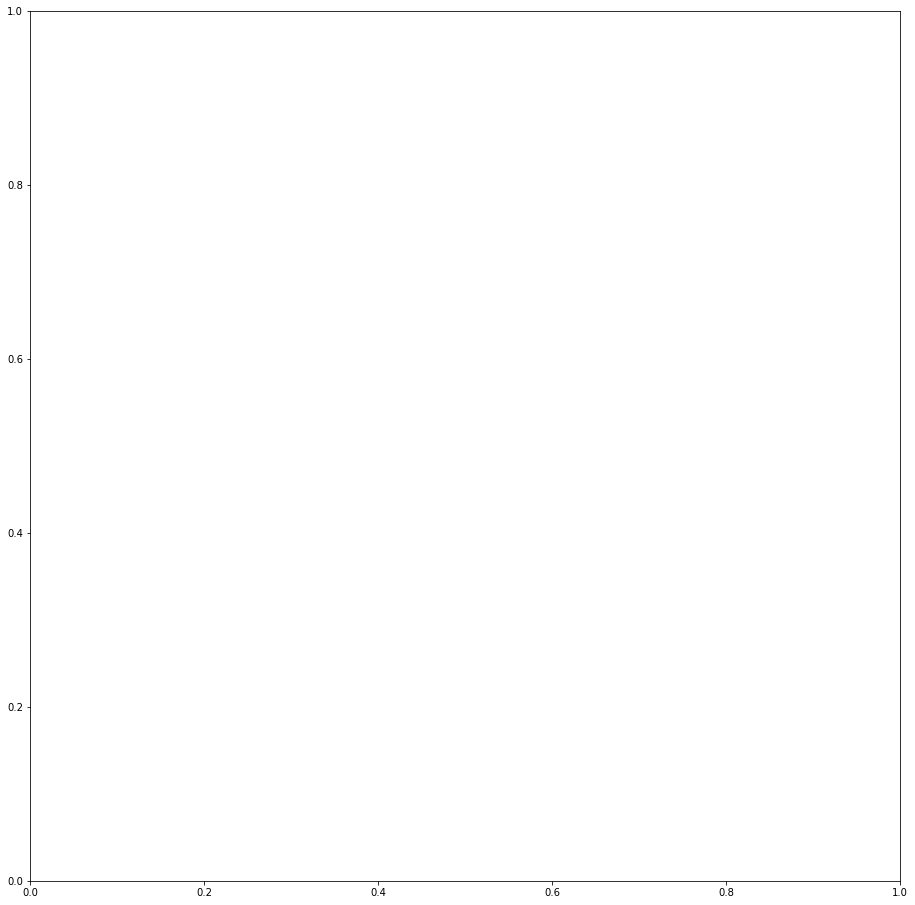

In [ ]:
df.plot(pred[:,6] , figsize=(16, 16), legend=True,)

In [22]:
import matplotlib.pyplot as plt

TypeError: Invalid shape (11750,) for image data

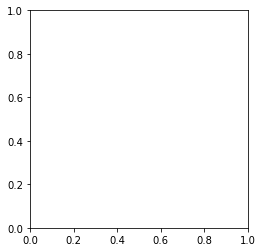

In [23]:
plt.imshow(pred[:,6])

In [24]:
pred[:,6]

array([0.00570888, 0.01290561, 0.06529924, ..., 0.20325065, 0.35793984,
       0.47191107], dtype=float32)